In [1]:
using Cxx
using PyCall
using PyPlot

@pyimport imageio

In [5]:
@pyimport skimage

In [12]:
@pyimport skimage.transform as transform

In [1007]:
include("src/Tracking.jl")

import Tracking
T = Tracking;

In [989]:
# video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/ch02_20180330092923.mp4"
video_file = "/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_hard_cut.mp4"

"/home/viktor/VirtualBox VMs/Shared/VehicleTracking/vehicle_videos/4K_hard_cut.mp4"

In [16]:
reader = imageio.get_reader(video_file);
#writer = imageio.get_writer("~/tmp/out.mp4", fps=reader[:get_meta_data]()["fps"]);

frames = [T.preprocess_frame(reader[:get_data](i)) for i in 900:1400];
background = T.init_background_weighted(frames);

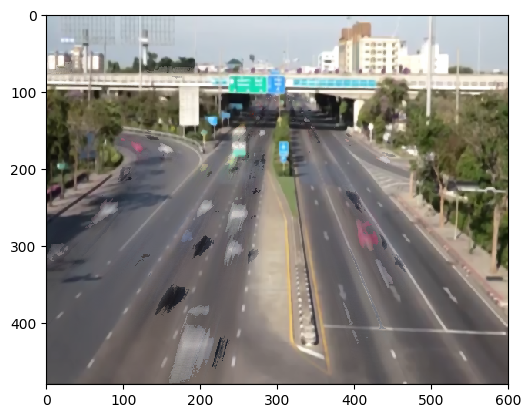

In [17]:
# for (i, frame) in enumerate(reader[:iter_data]())
for (i, frame) in enumerate(frames)
#     if i > 100
#         break
#     end
    
#     frame = T.preprocess_frame(frame);
    foreground = T.subtract_background(frame, background, 0.1);

#    foreground = T.suppress_shadows(frame, background, foreground, 0.6, 0.6, 0.3, 0.7);
#     vehicle_boxes = T.foreground_bounding_boxes(foreground);

#     writeVideo(writer, img);

    background = T.update_background(frame, background, foreground, 0.95);
end

imshow(background);

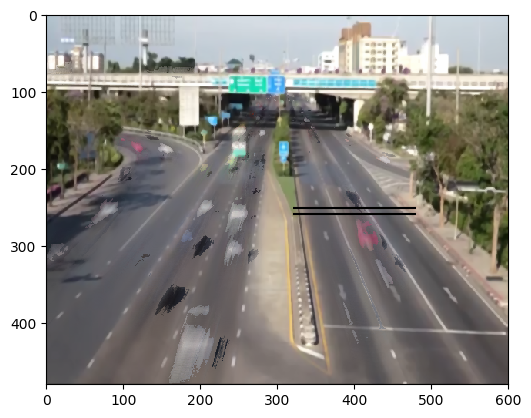

In [426]:
# slit_x = 285;
# slit_y = 200;
# slit_width = 80;
slit_x = 320;
slit_y = 250;
slit_width = 160;

block_width = 10;
block_height = 8;

imshow(background)
PyPlot.hlines(slit_y, xmin=slit_x, xmax=slit_x + slit_width)
PyPlot.hlines(slit_y + block_height, xmin=slit_x, xmax=slit_x + slit_width);

In [1031]:
threshold = 0.05

0.05

In [1064]:
include("src/StMrf.jl")
import StMrf
SM = StMrf;

blocks = Array{SM.Block, 2}(floor(Int, size(background, 1) / block_height) - 1, floor(Int, size(background, 2) / block_width) - 1)
for row_id in 1:size(blocks, 1)
    const row_start = row_id * block_height;
    for col_id in 1:size(blocks, 2)
        const col_start = col_id * block_width;
        blocks[row_id, col_id] = SM.Block(col_start, row_start, block_width, block_height);
    end
end

slit_coords = [SM.get_block_coords(slit_x + i * block_width, slit_y, block_width, block_height) for i in 1:floor(Int, slit_width / block_width)]
slit_line = [blocks[c...] for c in slit_coords];

new_object_id = 1;
f_id = 291;

last_id = 6
last_id = 6
last_id = 6
last_id = 6


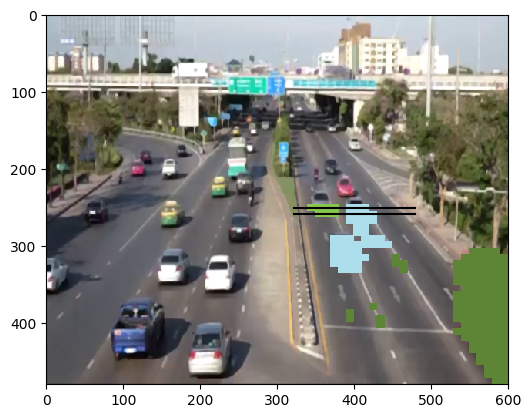

last_id = 6


In [1091]:
frame = frames[f_id];
motion_vecs = []
new_map = []
for i in 1:5
    if f_id >= size(frames, 1)
        break
    end
    
    frame = frames[f_id];
#     last_id = SM.update_slit_objects2!(slit_line, frame, background, new_object_id; threshold=threshold);
    last_id = SM.update_slit_objects2!(blocks, slit_coords, frame, background, new_object_id; threshold=threshold);
    new_object_id = max(new_object_id, last_id)
    @show last_id
    
    old_frame = frame;
    frame = frames[f_id + 1];

    obj_ids_map = map(b -> b.object_id, blocks);

    block_ids = unique(obj_ids_map);
    block_ids = block_ids[block_ids .> 0]
    group_coords = [collect(zip(findn(obj_ids_map .== id)...)) for id in block_ids]
    motion_vecs = [SM.find_motion_vector(blocks, frame, old_frame, gc) for gc in group_coords]
    motion_vecs_rounded = [SM.round_motion_vector(mv, block_width, block_height) for mv in motion_vecs]
    
    if size(motion_vecs, 1) == 0
        f_id += 1
        continue
    end

    new_map = SM.update_object_ids(blocks, obj_ids_map, motion_vecs_rounded, group_coords, frame, background; 
                                   threshold=threshold);
    new_map[map(x -> x.end_y, blocks) .< slit_y] = Set();

    for (b, ids) in zip(blocks, new_map)
        if length(ids) == 0
            b.object_id = 0
            continue
        end
        b.object_id = collect(ids)[1]
    end

    f_id += 1
end

plot_frame = deepcopy(frame);
for b in blocks
    if b.object_id == 0
        continue
    end

    srand(b.object_id)

    plot_frame[b.y_inds(), b.x_inds(),1] .= rand()
    plot_frame[b.y_inds(), b.x_inds(),2] .= rand()
    plot_frame[b.y_inds(), b.x_inds(),3] .= rand()
end

T.plot_frame(plot_frame, slit_x, slit_y, slit_width, block_height);

In [1027]:
sum(map(b -> b.object_id, blocks))

0

In [926]:
group_coords

3-element Array{Array{Tuple{Int64,Int64},1},1}:
 Tuple{Int64,Int64}[(31, 34), (31, 35), (31, 36)]                    
 Tuple{Int64,Int64}[(31, 40)]                                        
 Tuple{Int64,Int64}[(31, 42), (31, 43), (31, 44), (31, 45), (31, 46)]

$U_N(N_{y_k})$: Pott's J = -$\alpha$;  
$M_{xy_k}$: number of overlapping pixel labels  
$D_{xy_k}$: image difference between a block in the previous frame and displaced block in the current frame;  

In [795]:
gc = group_coords[1];
vecs = motion_vecs[1];

In [812]:
# n_classes = maximum(map(v -> maximum(union(v, 0)), new_map));

In [873]:
unary_penalties = fill(-100000, (size(blocks[:], 1), size(group_coords, 1) + 1));
unary_penalties[map(length, new_map)[:] .== 0, end] = 0;

for coords in gc
    block_id = collect(coords)' * [size(blocks, 2), 1]
    block = blocks[block_id];
    img_diff = sum(abs.(frame[block.coords()...] - old_frame[block.coords(-1 .* vecs)...]))
    for lab_id in new_map[coords...]
        unary_penalties[block_id, lab_id] = 
    end
end